<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/FinancialTimeSeries_Forecasting_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%%**********************]  1 of 1 completed
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Bollinger_Upper', 'Bollinger_Middle', 'Bollinger_Lower', 'RSI',
       'MACD_12_26', 'MACD_12_26_Signal', 'MACD_12_26_Hist', 'ATR',
       'Close_lag1', 'Close_lag2', 'Close_lag3', 'Bollinger_Upper_lag1',
       'Bollinger_Upper_lag2', 'Bollinger_Upper_lag3', 'Bollinger_Middle_lag1',
       'Bollinger_Middle_lag2', 'Bollinger_Middle_lag3',
       'Bollinger_Lower_lag1', 'Bollinger_Lower_lag2', 'Bollinger_Lower_lag3',
       'rolling_mean', 'rolling_std', 'trend', 'day_of_week', 'month',
       'SMA_50', 'Close_lag1_lag1', 'Close_lag1_lag2', 'Close_lag1_lag3'],
      dtype='object')
Epoch 1/5
79/79 [==============================] - 8s 55ms/step - loss: 0.0066
Epoch 2/5
79/79 [==============================] - 6s 70ms/step - loss: 0.0012
Epoch 3/5
79/79 [==============================] - 4s 54ms/step - loss: 0.0013
Epoch 4/5
79/79 [==================

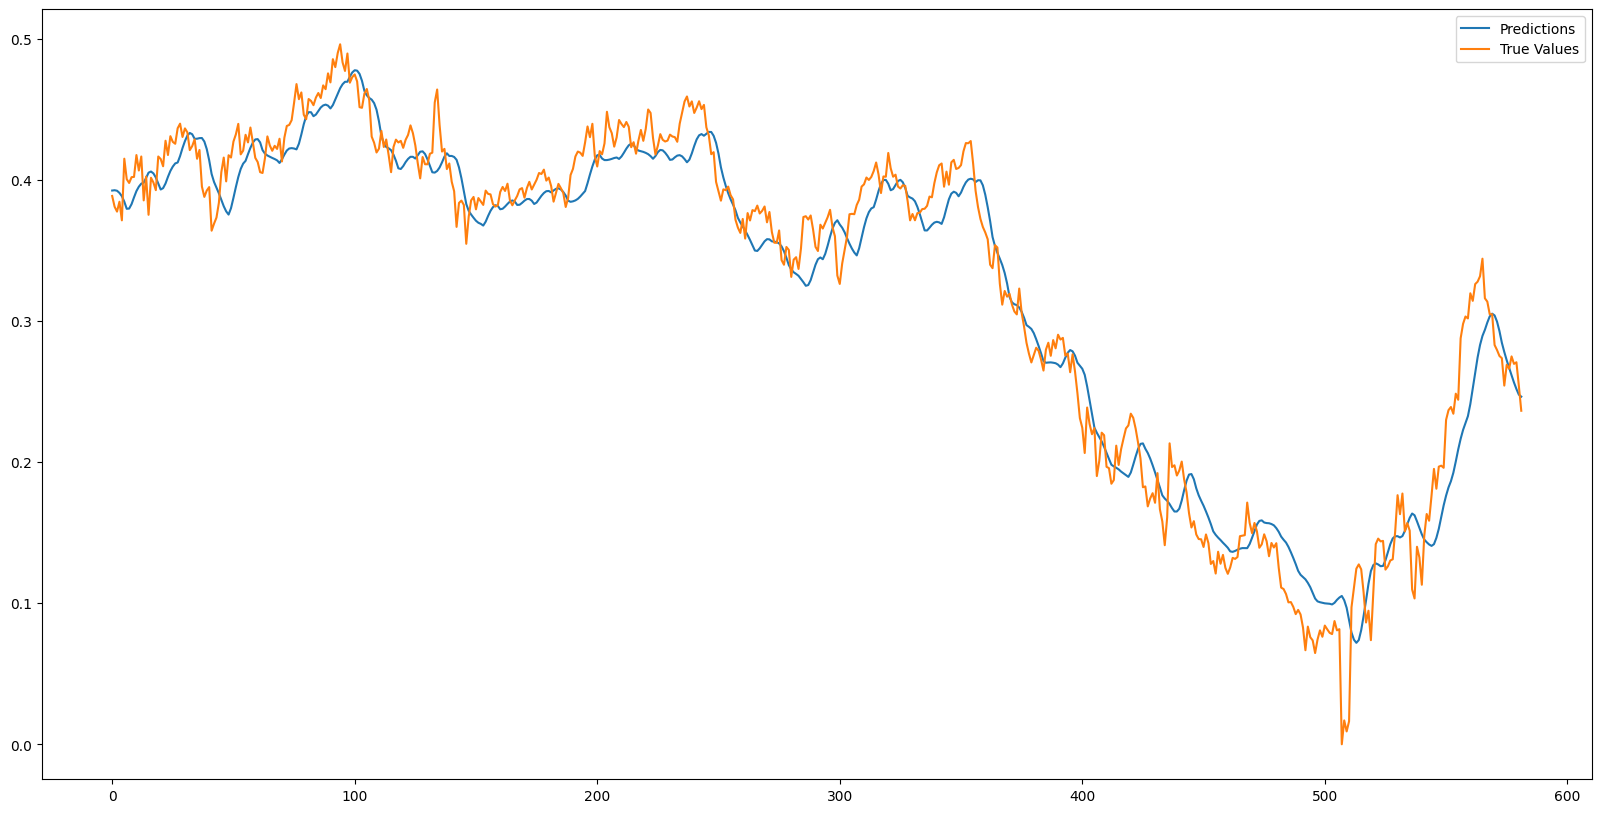

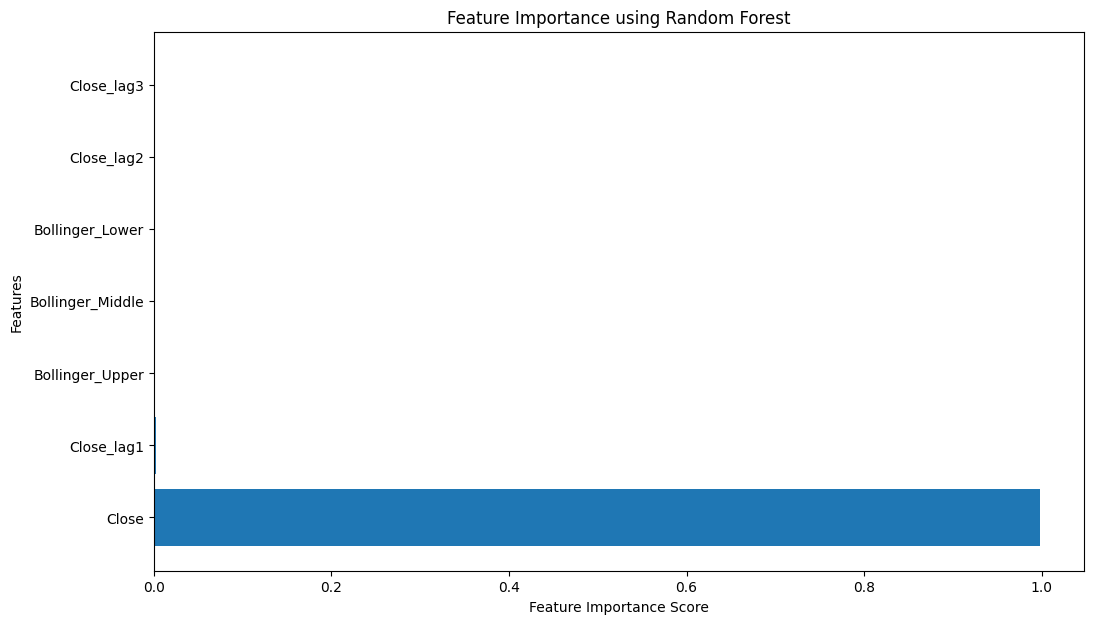

Selected Features: ['Close' 'Close_lag1' 'Bollinger_Upper' 'Bollinger_Middle'
 'Bollinger_Lower']
Highly Correlated Feature Pairs: [('Close', 'Close_lag1'), ('Close', 'Bollinger_Upper'), ('Close', 'Bollinger_Middle'), ('Close', 'Bollinger_Lower'), ('Close', 'Close_lag2'), ('Close', 'Close_lag3'), ('Close_lag1', 'Bollinger_Upper'), ('Close_lag1', 'Bollinger_Middle'), ('Close_lag1', 'Bollinger_Lower'), ('Close_lag1', 'Close_lag2'), ('Close_lag1', 'Close_lag3'), ('Bollinger_Upper', 'Bollinger_Middle'), ('Bollinger_Upper', 'Bollinger_Lower'), ('Bollinger_Upper', 'Close_lag2'), ('Bollinger_Upper', 'Close_lag3'), ('Bollinger_Middle', 'Bollinger_Lower'), ('Bollinger_Middle', 'Close_lag2'), ('Bollinger_Middle', 'Close_lag3'), ('Bollinger_Lower', 'Close_lag2'), ('Bollinger_Lower', 'Close_lag3'), ('Close_lag2', 'Close_lag3')]


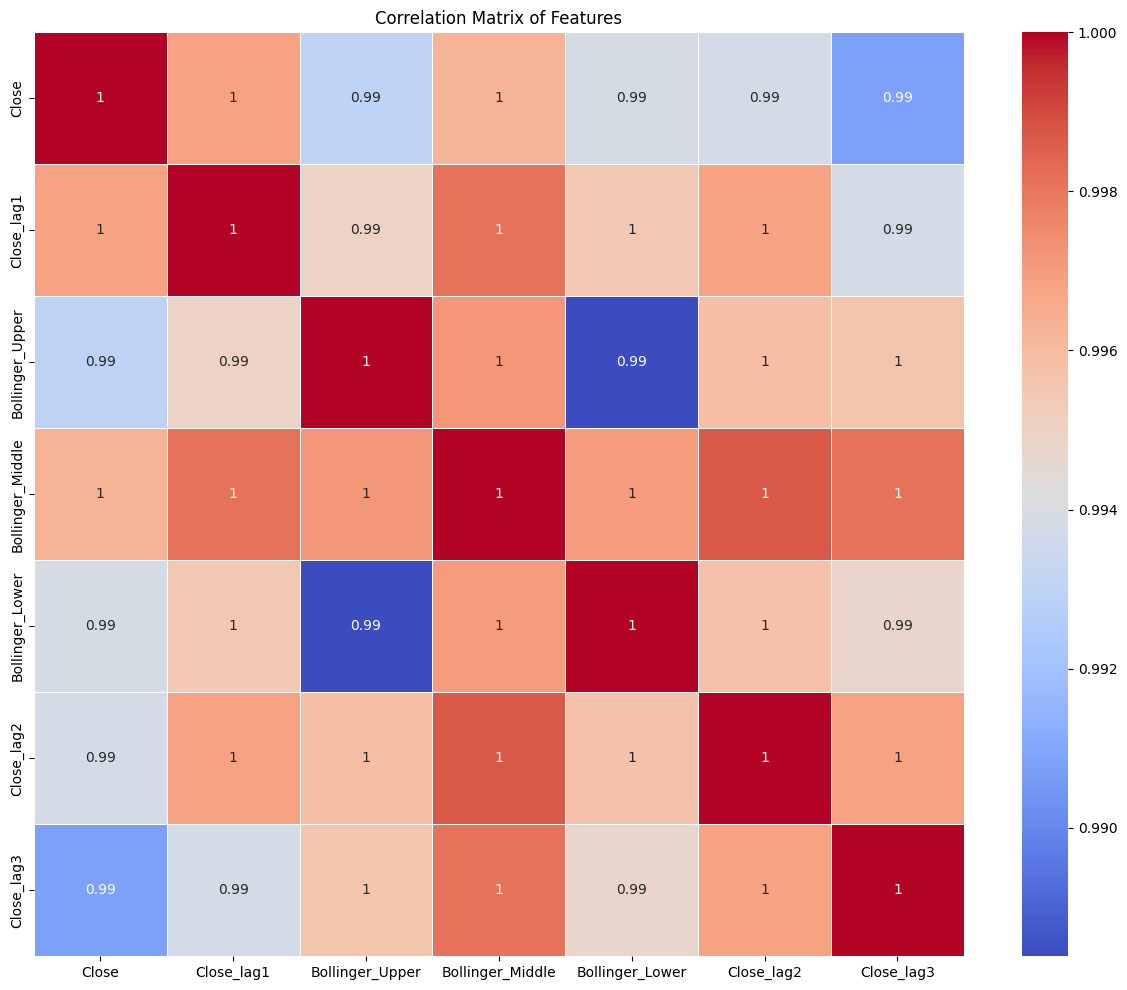

1/1 [==============================] - 0s 28ms/step


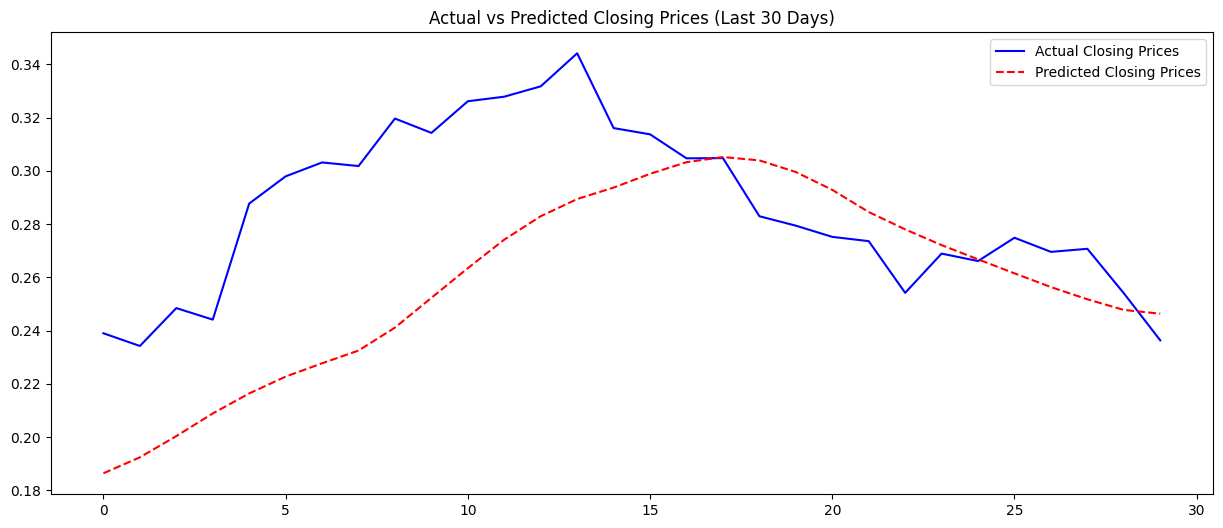

1/1 [==============================] - 0s 29ms/step
Predictions for the Next 6 Days: [0.24637159705162048, 0.24661582708358765, 0.24770626425743103, 0.24920020997524261, 0.25086408853530884, 0.25254228711128235]
Predicted Action for the Next 5 Days based on the 6 Days predictions: ['Buy', 'Buy', 'Buy', 'Buy', 'Buy']


In [18]:
!pip install pandas_ta yfinance
!pip install matplotlib

import datetime
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor

# Gather Data
symbol = "GBPCAD=X"
start_date = "2010-01-01"
end_date = datetime.datetime.now().strftime("%Y-%m-%d")
df_euraud = yf.download(symbol, start=start_date, end=end_date, interval="1d")

# Calculate Bollinger Bands
bbands_values = ta.bbands(df_euraud["Close"])
df_euraud["Bollinger_Upper"] = bbands_values["BBU_5_2.0"]
df_euraud["Bollinger_Middle"] = bbands_values["BBM_5_2.0"]
df_euraud["Bollinger_Lower"] = bbands_values["BBL_5_2.0"]

# Calculate technical indicators
df_euraud["RSI"] = ta.rsi(df_euraud["Close"])
df_euraud[["MACD_12_26", "MACD_12_26_Signal", "MACD_12_26_Hist"]] = ta.macd(df_euraud["Close"])
df_euraud["ATR"] = ta.atr(df_euraud["High"], df_euraud["Low"], df_euraud["Close"])

# Feature Engineering
input_features = ['Close', 'Bollinger_Upper', 'Bollinger_Middle', 'Bollinger_Lower']
num_lags = 3
for feature in input_features:
    for lag in range(1, num_lags + 1):
        df_euraud[f"{feature}_lag{lag}"] = df_euraud[feature].shift(lag)

window_size = 7
df_euraud["rolling_mean"] = df_euraud["Close"].rolling(window=window_size).mean()
df_euraud["rolling_std"] = df_euraud["Close"].rolling(window=window_size).std()

decomposition = seasonal_decompose(df_euraud["Close"], model='multiplicative', period=365)
df_euraud["trend"] = decomposition.trend

df_euraud['Date'] = pd.date_range(start=start_date, periods=len(df_euraud), freq='D')
df_euraud['Date'] = pd.to_datetime(df_euraud['Date'])
df_euraud["day_of_week"] = df_euraud['Date'].dt.dayofweek
df_euraud["month"] = df_euraud['Date'].dt.month
df_euraud.drop('Date', axis=1, inplace=True)

df_euraud["SMA_50"] = ta.sma(df_euraud["Close"], length=50)

# Drop NaN values and reset the index
df_euraud.dropna(inplace=True)
df_euraud.reset_index(drop=True, inplace=True)

# Preprocess Data
#input_features = ['Close', 'MACD_12_26', 'MACD_12_26_Signal']
#input_features = ['Close', 'Close_lag1', 'Bollinger_Upper', 'Bollinger_Middle', 'Bollinger_Lower']
# Preprocess Data
input_features = ['Close', 'Close_lag1', 'Bollinger_Upper', 'Bollinger_Middle', 'Bollinger_Lower']

# Feature Engineering
num_lags = 3
for feature in input_features:
    for lag in range(1, num_lags + 1):
        df_euraud[f"{feature}_lag{lag}"] = df_euraud[feature].shift(lag)

window_size = 7
df_euraud["rolling_mean"] = df_euraud["Close"].rolling(window=window_size).mean()
df_euraud["rolling_std"] = df_euraud["Close"].rolling(window=window_size).std()

decomposition = seasonal_decompose(df_euraud["Close"], model='multiplicative', period=365)
df_euraud["trend"] = decomposition.trend

df_euraud['Date'] = pd.date_range(start=start_date, periods=len(df_euraud), freq='D')
df_euraud['Date'] = pd.to_datetime(df_euraud['Date'])
df_euraud["day_of_week"] = df_euraud['Date'].dt.dayofweek
df_euraud["month"] = df_euraud['Date'].dt.month
df_euraud.drop('Date', axis=1, inplace=True)

df_euraud["SMA_50"] = ta.sma(df_euraud["Close"], length=50)

# Bollingeur Bands
# Calculate Bollinger Bands only once
#bbands_values = ta.bbands(df_euraud["Close"])
#df_euraud["Bollinger_Upper"] = bbands_values["BBU_5_2.0"]
#df_euraud["Bollinger_Middle"] = bbands_values["BBM_5_2.0"]
#df_euraud["Bollinger_Lower"] = bbands_values["BBL_5_2.0"]

# You can drop NaNs after all the calculations to ensure that no rows are prematurely dropped.
#df_euraud.dropna(inplace=True)


# Update the input_features list to include new features
input_features.extend([f"{feature}_lag{lag}" for feature in input_features for lag in range(1, num_lags + 1)])
input_features.extend(["rolling_mean", "rolling_std", "trend", "day_of_week", "month", "SMA_50", "Bollinger_Upper", "Bollinger_Middle", "Bollinger_Lower"])

df_scaler = MinMaxScaler()
df_euraud[input_features] = df_scaler.fit_transform(df_euraud[input_features])
close_scaler = MinMaxScaler()
df_euraud['Close'] = close_scaler.fit_transform(df_euraud[['Close']])

print(df_euraud.columns)
df_euraud.rename(columns={'BOLL_U': 'Bollinger_Upper', 'BOLL_M': 'Bollinger_Middle', 'BOLL_L': 'Bollinger_Lower'}, inplace=True)

#df_euraud['Bollinger_Upper'], df_euraud['Bollinger_Middle'], df_euraud['Bollinger_Lower'] = df_euraud['Close'].ta.bbands()

# Split Data
train_size = int(len(df_euraud) * 0.8)
train_data = df_euraud[:train_size]
test_data = df_euraud[train_size:]

def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length - 1):
        sequence = data[i : i + seq_length][input_features].values
        label = data["Close"].iloc[i + seq_length]
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 60
train_x, train_y = create_sequences(train_data, seq_length)
test_x, test_y = create_sequences(test_data, seq_length)

#check data
train_x = np.nan_to_num(train_x)
train_y = np.nan_to_num(train_y)
test_x = np.nan_to_num(test_x)
test_y = np.nan_to_num(test_y)

# Build Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, kernel_initializer='glorot_uniform', input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(LSTM(units=50, kernel_initializer='glorot_uniform'))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Reduce learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Gradient clipping
optimizer = keras.optimizers.Adam(learning_rate=0.001, clipvalue=1.0)

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(train_x, train_y, epochs=5, batch_size=32)

# Predict using the model
predictions = model.predict(test_x)
predictions_rescaled = close_scaler.inverse_transform(predictions)

print(df_euraud.isnull().sum())
print("NaN in predictions:", np.isnan(predictions_rescaled).sum())
print("NaN in test_y:", np.isnan(close_scaler.inverse_transform(test_y.reshape(-1, 1))).sum())

# Calculate metrics
rmse = np.sqrt(mean_squared_error(predictions_rescaled, close_scaler.inverse_transform(test_y.reshape(-1, 1))))
mae = mean_absolute_error(predictions_rescaled, close_scaler.inverse_transform(test_y.reshape(-1, 1)))

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# Visualization
plt.figure(figsize=(20, 10))
plt.plot(range(len(predictions_rescaled)), predictions_rescaled, label="Predictions")
plt.plot(range(len(predictions_rescaled)), close_scaler.inverse_transform(test_y.reshape(-1, 1)), label="True Values")
plt.legend()
plt.show()

# Feature Importance from Tree-Based Models
# First, ensure that there are no NaN values in the training data
df_euraud.dropna(inplace=True)

# Now, get the training size (assumes you've already defined a split ratio, e.g., 0.8 for 80%)
train_size = int(len(df_euraud) * 0.8)  # replace 0.8 if you're using a different split ratio

# Ensure that your input_features are correct (it seems from your code you're using lag features and others)
input_features = ['Close', 'Close_lag1', 'Bollinger_Upper', 'Bollinger_Middle', 'Bollinger_Lower', 'Close_lag2', 'Close_lag3']

# Then you can proceed with training your RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100)
rf.fit(df_euraud[input_features][:train_size], df_euraud["Close"][:train_size])

plt.figure(figsize=(12, 7))
plt.barh(input_features, rf.feature_importances_)
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance using Random Forest")
plt.show()

# Recursive Feature Elimination (RFE)
selector = RFE(rf, n_features_to_select=5, step=1)
selector = selector.fit(df_euraud[input_features][:train_size], df_euraud["Close"][:train_size])
selected_features = np.array(input_features)[selector.support_]
print("Selected Features:", selected_features)

# Correlation Matrix
correlation_matrix = df_euraud[input_features].corr().abs()

# Extract pairs of features with high correlation
highly_correlated_pairs = []
threshold = 0.8
for i in range(len(correlation_matrix)):
    for j in range(i+1, len(correlation_matrix)):
        if correlation_matrix.iloc[i, j] > threshold:
            highly_correlated_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))

print("Highly Correlated Feature Pairs:", highly_correlated_pairs)

# Visualize correlation matrix
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Features")
plt.show()

# Backtest Over Last 30 Days
recent_data = close_scaler.inverse_transform(test_y[-30:].reshape(-1, 1))
predicted_30_days = []

# To backtest over 30 days, start 30 days before the end of test_x
start_idx = len(test_x) - 30

for idx in range(start_idx, len(test_x)):
    input_data = test_x[idx]
    predicted_value = model.predict(np.array([input_data]))[0][0]
    predicted_30_days.append(close_scaler.inverse_transform(np.array([[predicted_value]]))[0][0])

# Plotting the results
plt.figure(figsize=(15, 6))
plt.plot(recent_data, label="Actual Closing Prices", color='blue')
plt.plot(predicted_30_days, label="Predicted Closing Prices", color='red', linestyle="--")
plt.title("Actual vs Predicted Closing Prices (Last 30 Days)")
plt.legend()
plt.show()

################################

# Predict the next 6 days
next_6_days = [test_x[-1]]
for _ in range(6):
    predicted_value = model.predict(np.array([next_6_days[-1]]))[0][0]
    last_day_features = next_6_days[-1][-1].copy()
    last_day_features[0] = predicted_value
    new_day = np.concatenate((next_6_days[-1][1:], [last_day_features]), axis=0)
    next_6_days.append(new_day)

predicted_closes = [close_scaler.inverse_transform(np.array([[day[-1, 0]]]))[0][0] for day in next_6_days][1:]

# Loop for 5 times to get decisions for the 6 days, since there are 5 comparisons to make
decisions = ['Buy' if predicted_closes[i + 1] > predicted_closes[i] else 'Sell' if predicted_closes[i + 1] < predicted_closes[i] else 'Hold' for i in range(5)]

print(f"Predictions for the Next 6 Days: {predicted_closes}")
print(f"Predicted Action for the Next 5 Days based on the 6 Days predictions: {decisions}")


Description:

This notebook provides a comprehensive framework to predict foreign exchange (forex) rates using technical analysis and deep learning. The given script focuses on predicting the EUR/USD forex rates but can be adapted for other currency pairs or financial instruments. The primary method is the use of Long Short-Term Memory networks (LSTM), a form of Recurrent Neural Networks (RNN), to predict future closing prices.

Key Components:

Data Gathering: Fetches historical forex rates for EUR/USD from Yahoo Finance, spanning from 2010 to the present date.
Technical Analysis: Computes technical indicators like RSI, MACD, and ATR for the historical data.
Data Preprocessing: Normalizes feature values and crafts sequences for LSTM training.
Model Building & Training: Constructs an LSTM model and trains it using the preprocessed sequences.
Evaluation: Computes Mean Squared Error (MSE) and Mean Absolute Error (MAE) on test data to assess model accuracy.
Predictive Action: Makes decisions (Buy, Sell, Hold) based on the predicted closing prices for the next 6 days.
Feature Selection: Explores feature selection methods, including correlation analysis, feature importance from Random Forest, and Recursive Feature Elimination (RFE).
Backtesting: Visualizes the model's performance over the last 30 days by comparing the actual vs. predicted closing prices.
Instructions for Use:

Installation: Start by installing the required libraries using the !pip install pandas_ta yfinance command.
Select Symbol: Choose your currency pair or financial instrument by setting the 'symbol' variable.
Run Entire Notebook: Execute all the cells. The notebook will fetch data, preprocess it, train the model, and make predictions.
Adjust Features: Based on the correlation heatmap and other feature selection techniques, decide on the features to be included in the model. You can comment/uncomment the input_features lines as needed.
Evaluate & Backtest: Observe the MSE and MAE values for model performance. Additionally, view the backtesting plot for the last 30 days to understand the model's predictive power visually.
Make Predictions: The model provides Buy, Sell, or Hold decisions for the next 6 days based on predicted closing prices.
Customize: Feel free to tweak hyperparameters, LSTM architecture, or even include other technical indicators for enhanced predictions.
Note: Forex markets are influenced by a multitude of factors. While technical indicators can provide insights, it's essential to combine these with fundamental analysis and other research methods for a holistic trading strategy. Always trade responsibly.